In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
import glob
from PIL import Image

In [2]:
def df_to_numpy(key_val):
    n = df[key_val].to_numpy()
    return n[~np.isnan(n)]

In [3]:
df = pd.read_excel("Exposure_Times.xlsx")
df.head()

k = []
names = ['Munger','Piano','Baymax']
for i in names:
    k.append(df_to_numpy(i))

k_munger = k[0]
k_piano = k[1]
k_baymax = k[2]

In [4]:
path = r'C:\Users\audre\OneDrive\Documents\GitHub\EE367_FinalProject\downsized_img'

img_arr = []
for n in names:
    if n == 'Munger':
        idx = 0
    elif n == 'Piano':
        idx = 1
    elif n == 'Baymax':
        idx = 2
    image_list = []
    directory = path + "\\" + n + "\\"
    print(directory)

    for i, filename in enumerate(glob.glob(directory+'*.JPG')): #assuming gif
        im= plt.imread(filename)
        image_list.append(im)
        
    img_arr.append(image_list)


C:\Users\audre\OneDrive\Documents\GitHub\EE367_FinalProject\downsized_img\Munger\
C:\Users\audre\OneDrive\Documents\GitHub\EE367_FinalProject\downsized_img\Piano\
C:\Users\audre\OneDrive\Documents\GitHub\EE367_FinalProject\downsized_img\Baymax\


In [5]:
baymax_arr = np.array(img_arr[2])
baymax_arr.shape

(37, 300, 400, 3)

In [6]:
new_baymax_arr = np.zeros((baymax_arr.shape[0],16,16,3), dtype = int)
for i, m in enumerate(baymax_arr):
    new_baymax_arr[i,:,:] = m[100:116,100:116]
new_baymax_arr.shape

(37, 16, 16, 3)

In [7]:
def get_w(z_new):

    if z_new <= 1/2 * 256:
        return z_new
    else:
        return 256 - z_new

In [8]:
def gsolve(Z, B, l, w):

    # n = the number of pixel values
    n = 256

    A = np.zeros((Z.shape[0]*Z.shape[1] + n + 1, n + Z.shape[0]))
    b = np.zeros((A.shape[0], 1))
    
    # Include the data-fitting equations
    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w(Z[i,j])
            A[k, Z[i,j]] = wij
            A[k, n + i] = -wij
            b[k] = wij * B[j]
            k += 1
            
    # Fix the curve by setting its middle value to 0
    A[k, 129] = 1
    k += 1
    
    # Include the smoothness equations
    for i in range(n-2):
        A[k, i] = l * w(i+1)
        A[k, i+1] = -2 * l * w(i+1)
        A[k, i+2] = l * w(i+1)
        k += 1
        
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:n].flatten()
    lE = x[n:].flatten()
    
    return g, lE


In [9]:
Z_baymax_arr = new_baymax_arr.transpose([1,2,3,0])
Z_baymax_arr = Z_baymax_arr.reshape((Z_baymax_arr.shape[0]*Z_baymax_arr.shape[1],Z_baymax_arr.shape[2],Z_baymax_arr.shape[3]))
B_munger_lst = np.log(k[2])
l = 0.1 
# l =0.000000000001



# for i in range(3):
g, le = gsolve(Z_baymax_arr[:,0,:],B_munger_lst,l,get_w)
gg, leg = gsolve(Z_baymax_arr[:,1,:],B_munger_lst,l,get_w)
gb, leb = gsolve(Z_baymax_arr[:,2,:],B_munger_lst,l,get_w)

In [10]:
len(g)
len(le)

256

Text(0.5, 1.0, '')

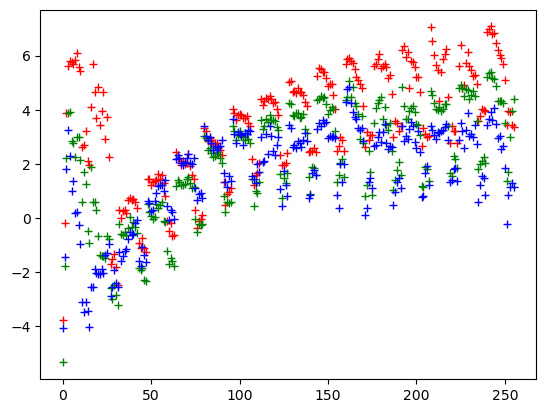

In [11]:
plt.plot(np.arange(256), g+le, '+', color = 'r')
plt.plot(np.arange(256), gg+leg, '+', color = 'g')
plt.plot(np.arange(256), gb+leb, '+', color = 'b')
plt.title('')


#plt.plot(np.arange(256), le, '+', color = 'r')

In [12]:
#pixel_value = np.exp(g[:, np.newaxis] + le) 
#plt.plot(le, pixel_value, 'bo')
#plt.xlabel('Log Exposure')
#plt.ylabel('Pixel Value')
#plt.title('Pixel Value by Log Exposure')
#plt.grid(True)


In [13]:
print(len(le))
print(len(k[2]))

le = np.reshape(le, (1,256))
leg = np.reshape(leg, (1,256))
leb = np.reshape(leb, (1,256))
k2  = np.reshape(k[2], (1,37))

256
37


In [14]:
print(le.shape)
print(k2.shape)

(1, 256)
(1, 37)


In [15]:
print(Z_baymax_arr[:,0,:].shape)

(256, 37)


In [16]:
a = le.T@k2
g = leg.T@k2
b = leb.T@k2

In [17]:
print(a.shape)

(256, 37)


In [18]:
Z_ij = Z_baymax_arr[:,0,:].flatten()
Ei_deltat = a.flatten()

g_f = g.flatten()
b_f = b.flatten()

print(len(Z_ij))
print(len(Ei_deltat))

9472
9472


Text(0, 0.5, 'Pixel Value')

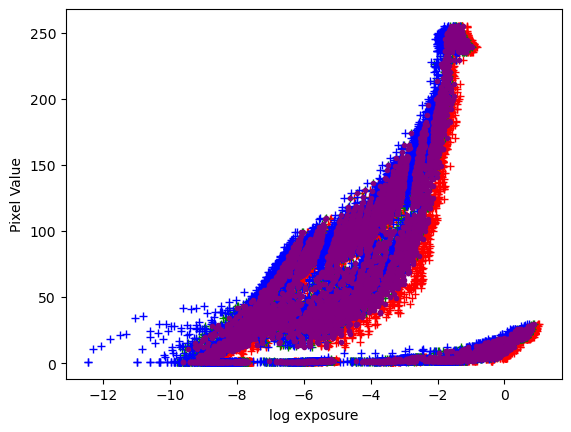

In [19]:
plt.plot(np.log(Ei_deltat),Z_ij, '+', color = 'red')
plt.plot(np.log(g_f),Z_ij, '+', color = 'green')
plt.plot(np.log(b_f),Z_ij, '+', color = 'blue')
plt.plot(np.log((Ei_deltat+g_f+b_f)/3),Z_ij, '.', color = 'purple')
plt.xlabel('log exposure')
plt.ylabel('Pixel Value')


In [20]:
from scipy.optimize import curve_fit

In [21]:
def objective(x, a, b):
	# return a**(b * np.exp(x)) + c * np.exp(x) + d 
    return a * np.exp(b*x)

x = np.log((Ei_deltat+g_f+b_f)/3)
y = Z_ij

popt, _ = curve_fit(objective, x, y)
a, b = popt
# print('y = %.5f e^()' % (a, b, c))
a,b

c:\Users\audre\anaconda3\envs\ee367-hw\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\audre\anaconda3\envs\ee367-hw\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


(97.97791983107136, 0.07692497456851817)

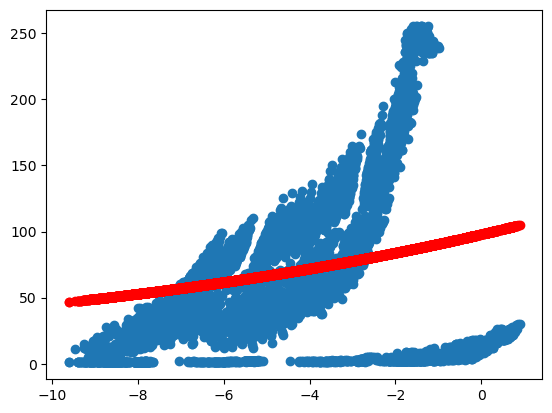

In [22]:
plt.scatter(x,y)
plt.plot(x, objective(x, a, b),'ro')

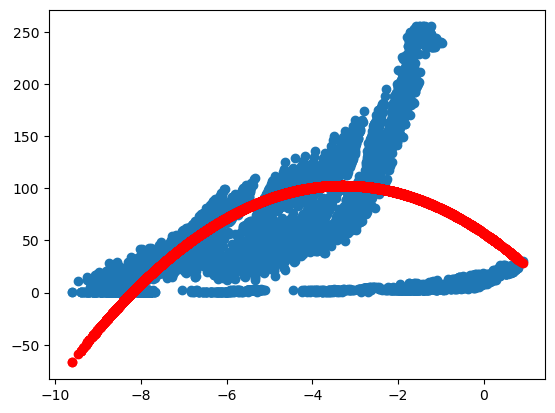

In [23]:
params = np.polyfit(x,y,2)
plt.scatter(x,y)
plt.plot(x, params[0]*x**2+params[1]*x+params[2],'ro')

### Save CSV for MATLAB processing

In [24]:
import pandas as pd
xy = np.array([x,y])
df = pd.DataFrame(xy.T)
# df.to_csv('log_exp_px_val.csv')

In [25]:
# plt.plot(Ei_deltat,Z_ij, '+', color = 'red')
# plt.plot(g_f,Z_ij, '+', color = 'green')
# plt.plot(b_f,Z_ij, '+', color = 'blue')


In [26]:
def justify(a, invalid_val=0, axis=1, side='left'):    
    """
    Justifies a 2D array

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """

    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val) 
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

In [27]:
df_y = pd.DataFrame(xy.T)

df_y = df_y.where(df_y[1] > 30, np.nan)
arr = justify(df_y.to_numpy(), invalid_val=np.nan, axis=0, side='up')
#oldier pandas versions
# arr = justify(df.values, invalid_val=np.nan, axis=0, side='up')
df_y = pd.DataFrame(arr)
df_y

,0,1
0,-7.608751,35.0
1,-7.369494,43.0
2,-7.103938,55.0
3,-6.808996,64.0
4,-6.642212,73.0
...,...,...
9467,NaN,NaN
9468,NaN,NaN
9469,NaN,NaN
9470,NaN,NaN


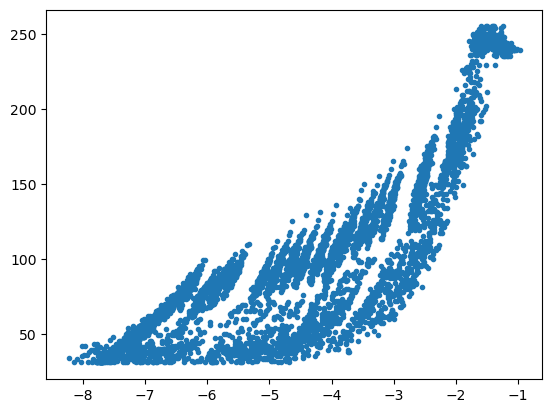

In [28]:
plt.plot(df_y[0],df_y[1],'.')

In [29]:
# df_y.to_csv('log_exp_px_val_cleaned.csv')

### From MATLAB curve fitting

Got an equation with coeffs for camera response function

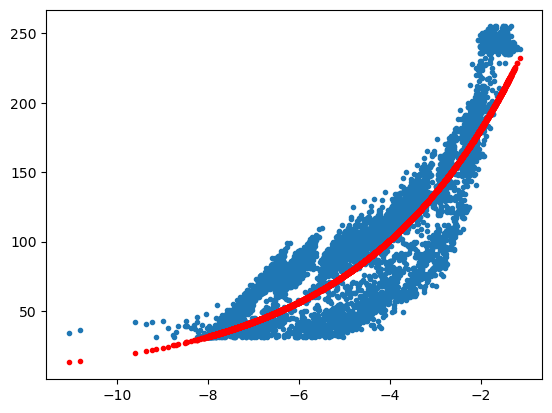

In [43]:
a =       324.9  
b =      0.2917  
fitted_y = a * np.exp(b*df_y[0].to_numpy())
plt.plot(df_y[0],df_y[1],'.')
plt.plot(df_y[0],fitted_y,'r.')

### For each individual channel

In [37]:
# plt.plot(np.log(Ei_deltat),Z_ij, '+', color = 'red')
# plt.plot(np.log(g_f),Z_ij, '+', color = 'green')
# plt.plot(np.log(b_f),Z_ij, '+', color = 'blue')
x_ch1 = np.log(Ei_deltat)
x_ch2 = np.log(g_f)
x_ch3 = np.log(b_f)

y = Z_ij
xy_3 = np.array([x_ch3,y])

In [38]:
df_y = pd.DataFrame(xy_3.T)

df_y = df_y.where(df_y[1] > 30, np.nan)
arr = justify(df_y.to_numpy(), invalid_val=np.nan, axis=0, side='up')
#oldier pandas versions
# arr = justify(df.values, invalid_val=np.nan, axis=0, side='up')
df_y = pd.DataFrame(arr)
df_y

,0,1
0,-7.795123,35.0
1,-7.555867,43.0
2,-7.290310,55.0
3,-6.995369,64.0
4,-6.828584,73.0
...,...,...
9467,NaN,NaN
9468,NaN,NaN
9469,NaN,NaN
9470,NaN,NaN


In [39]:
df_y.to_csv('log_exp_px_val_cleaned_ch3.csv')

#### CH1 coeffs

In [44]:
a =       302.7  #(299.2, 306.2)
b =      0.2897  #(0.2858, 0.2937)
fitted_y_ch1 = a * np.exp(b*df_y[0].to_numpy())

In [46]:
a =       330.7  #(327.3, 334.2)
b =      0.2924  #(0.289, 0.2958)
fitted_y_ch2 = a * np.exp(b*df_y[0].to_numpy())

In [49]:
a =       344.4  #(340.3, 348.5)
b =      0.2889  #(0.2853, 0.2925)
fitted_y_ch3 = a * np.exp(b*df_y[0].to_numpy())

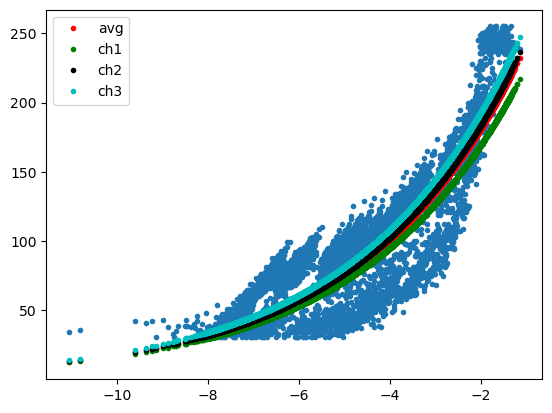

In [52]:

plt.plot(df_y[0],df_y[1],'.')
plt.plot(df_y[0],fitted_y,'r.',label='avg')
plt.plot(df_y[0],fitted_y_ch1,'g.',label='ch1')
plt.plot(df_y[0],fitted_y_ch2,'k.',label='ch2')
plt.plot(df_y[0],fitted_y_ch3,'c.',label='ch3')
plt.legend()

### Grayscale

In [39]:
from skimage import color
from skimage import io

img = color.rgb2gray(baymax_arr[13])
img = np.rot90(img,3)

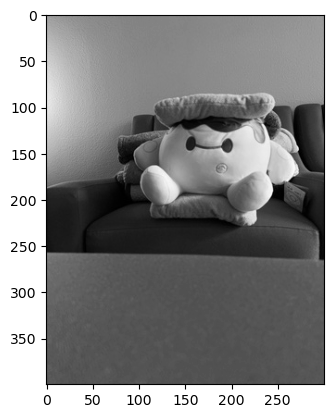

In [40]:
plt.imshow(img, cmap = 'gray')

In [41]:
img.shape


(400, 300)

In [42]:
gray_baymax_arr = color.rgb2gray(baymax_arr)
gray_baymax_arr.shape
gray_baymax_arr *= 255
gray_baymax_arr

array([[[ 3.8558,  2.8558,  2.8558, ...,  2.    ,  2.    ,  2.    ],
        [ 2.8558,  2.8558,  2.8558, ...,  2.    ,  2.    ,  2.    ],
        [ 2.8558,  2.8558,  2.8558, ...,  2.    ,  2.    ,  2.    ],
        ...,
        [ 2.8558,  2.8558,  2.8558, ...,  2.    ,  2.    ,  2.    ],
        [ 2.8558,  2.8558,  2.8558, ...,  2.    ,  2.    ,  2.    ],
        [ 2.8558,  2.8558,  2.8558, ...,  2.    ,  2.    ,  2.    ]],

       [[ 4.    ,  4.    ,  4.    , ...,  3.    ,  2.    ,  2.    ],
        [ 3.    ,  3.    ,  3.    , ...,  2.    ,  2.    ,  2.    ],
        [ 3.    ,  3.    ,  3.    , ...,  2.    ,  2.    ,  2.    ],
        ...,
        [ 3.8558,  3.8558,  3.8558, ...,  3.    ,  2.    ,  2.    ],
        [ 3.8558,  3.8558,  2.8558, ...,  3.    ,  2.    ,  2.    ],
        [ 3.8558,  2.8558,  2.8558, ...,  3.    ,  2.    ,  2.    ]],

       [[41.9886, 43.9886, 45.9886, ..., 25.0683, 27.0683, 30.4971],
        [44.9886, 44.9886, 43.9886, ..., 25.4971, 24.4971, 23.4971],
    

In [43]:
new_baymax_arr = np.zeros((gray_baymax_arr.shape[0],16,16), dtype = int)
for i, m in enumerate(gray_baymax_arr):
    new_baymax_arr[i,:,:] = m[150:166,150:166]
new_baymax_arr.shape

(37, 16, 16)

In [48]:
new_baymax_arr[0,:,:]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1],
       [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2]])

In [ ]:
Z_baymax_arr = new_baymax_arr.transpose([1,2,0])
Z_baymax_arr = Z_baymax_arr.reshape((Z_baymax_arr.shape[0]*Z_baymax_arr.shape[1],Z_baymax_arr.shape[2]))
B_munger_lst = np.log(k[2])
l = 0.1



# for i in range(3):
g, le = gsolve(Z_baymax_arr,B_munger_lst,l,get_w)


In [ ]:
Z_baymax_arr

array([[ 1,  1, 40, ..., 19, 24, 30],
       [ 1,  2, 36, ..., 18, 27, 31],
       [ 1,  2, 40, ..., 20, 25, 31],
       ...,
       [ 2,  2, 43, ..., 21, 29, 34],
       [ 2,  2, 43, ..., 23, 29, 35],
       [ 2,  2, 43, ..., 24, 30, 35]])

In [ ]:
le = np.reshape(le, (1, len(le)))

In [ ]:
a.shape

(256, 37)

In [ ]:
a = le.T@k2
Ei_deltat = a.flatten()
Z_ij = new_baymax_arr.flatten()

In [ ]:
Ei_deltat


array([5.98320543e-04, 5.98320543e-04, 6.91830958e-04, ...,
       1.34584878e+00, 2.24308129e+00, 3.36462194e+00])

Text(0, 0.5, 'Pixel Value')

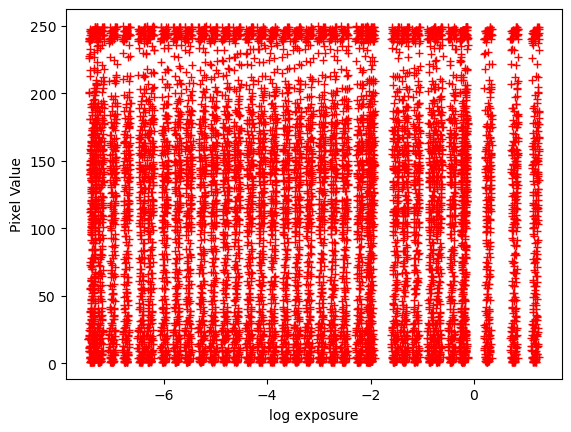

In [ ]:
plt.plot(np.log(Ei_deltat), Z_ij, '+', color = 'red')
plt.xlabel('log exposure')
plt.ylabel('Pixel Value')
